<IPython.core.display.Javascript object>


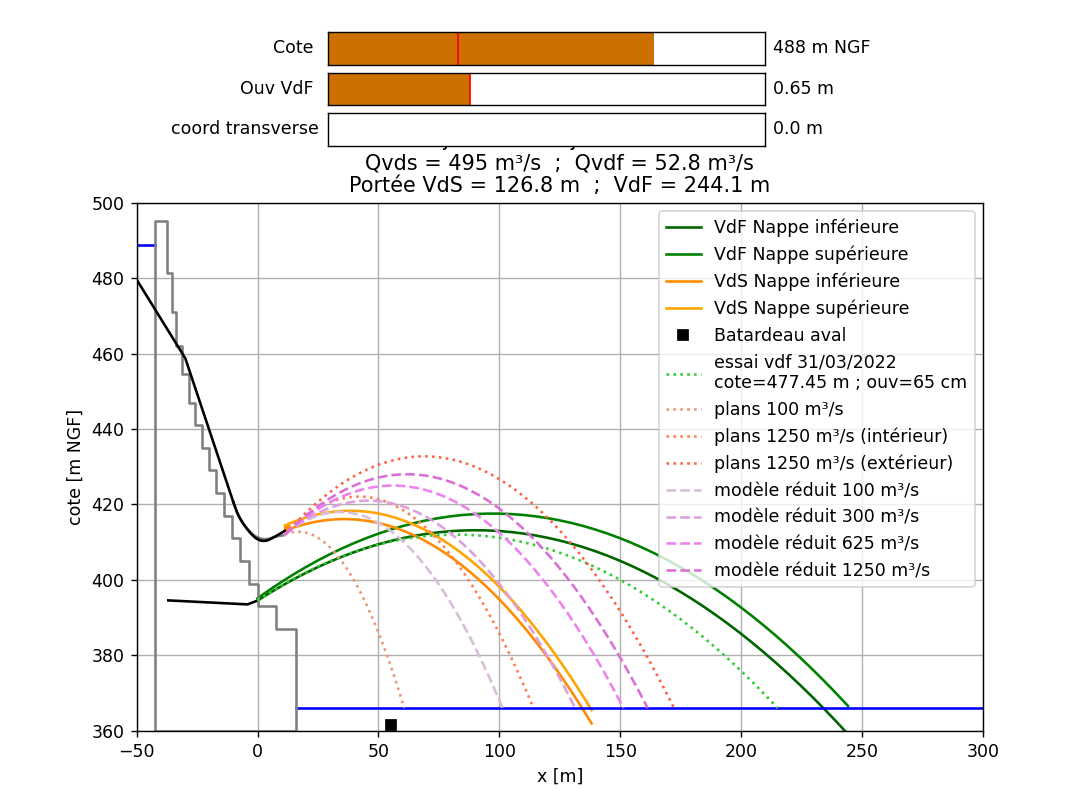

JET VDF : Q=49.59 m3/s ; ouv=0.65 m
theta_vanne=49.249° ; m=0.811
Fr=21 ; h0=0.53 m ; v0=47.07 m/s
22.4° < alpha < 24.8°
Flèche=414.9 m NGF ; Portée=220.1 m



0

In [5]:
# -*- coding: utf-8 -*-
"""
Created on Fri Jun 17 10:29:05 2022

@author: J84880
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
%matplotlib notebook
g = 9.81
AFFICHE_INFO = 1

#DONNES GEO (définies à portée globale pour les sliders et la composition des éléments de contexte)
ouv = 0.65 #essai 31/03/22
cote = 477.45 #essai 31/03/22
cote_aval = 366
cote_ejec_vdf = 394.5
cote_ejec_vds = 412 #z moyen selon l'axe transverse de l'extrémité cuillère
ouv_max = 2
dist_vdf_parementAmont = 42.7 #plans conformes page 3
dist_ejecVdS_parementAmont = 54 #plans modeles reduits excel Benoit
x_ejecVdS = dist_ejecVdS_parementAmont - dist_vdf_parementAmont
l_cuillere = 9.6 #largeur du coursier des EVC (VdS) à son extremité aval
phi_canal_vds = 62.48743
phi_canal_vdf = 1.83
dist_vdf_batardeauAval = 55.07

def rad(angle):
    return angle*np.pi/180
def deg (angle):
    return angle*180/np.pi
def interpolate(tabx, tabf, valx):
    if tabx[0] > valx or tabx[-1] < valx:
        raise ValueError("Extrapolation impossible") 
    for i in range(len(tabx)):
        if tabx[i] == valx:
            return tabf[i]
        if tabx[i] > valx: #interpolation (linear)
            a = (tabf[i]-tabf[i-1])/(tabx[i]-tabx[i-1])
            b = (tabx[i]*tabf[i-1] - tabx[i-1]*tabf[i]) / (tabx[i]-tabx[i-1])
            return a * valx + b
def interpolate_2d(tabx, taby, matf, valx, valy):
    if tabx[0] > valx or tabx[-1] < valx:
        raise ValueError("Extrapolation impossible") 
    for i in range(len(tabx)):
        if tabx[i] == valx:
            return interpolate(taby, matf[i], valy)
        if tabx[i] > valx: #interpolation (linear)
            for j in range(len(matf[i])):
                a = (matf[i][j]-matf[i-1][j])/(tabx[i]-tabx[i-1])
                b = (tabx[i]*matf[i-1][j] - tabx[i-1]*matf[i][j]) / (tabx[i]-tabx[i-1])
                matf[i][j] = a * valx + b
            return interpolate(taby, matf[i], valy)
def trajectoire_fit(z_jet, fleche, portee, dx=0):
    """Calcule la trajectoire balistique à partir des observables (portée et flèche) :
        le jet démarre au point x=0, z=z_jet
        il atteint son maximum (z=fleche), APRES le point d'éjection
        il atterit à la surface aval (z=cote_aval) à x=portee
        dx permet de décaler l'origine des x après le calcul"""
    c = z_jet
    fp = fleche - c #projette la flèche dans le repère où z'=0 est l'origine du jet
    
    a = - fp / portee**2 * (-1 - np.sqrt(1+(c-cote_aval)/fp))**2
    b = np.sqrt(-4*a*fp)

    x = np.linspace(0,portee)
    z = a*np.power(x, 2) + b*x + c
    return np.add(x, dx), z
def theta_ouv_vanne_segment(ouv, r_vanne, dz_pivotVanne_seuilVanne):
    return deg(np.arccos((dz_pivotVanne_seuilVanne - ouv) / r_vanne))
def coeff_contraction(ouv_max, ouv, theta_v_segment):
    zeta = 0.4*np.sin(rad(theta_v_segment))**3
    return 1/(1+np.sqrt(zeta*(1-(ouv/ouv_max)**2)))
def portee(alpha, Fr, h0, z_ini):
    """résolution du polynome avec alpha_inf pour calculer la portée"""
    z_fin = cote_aval - z_ini
    A = h0 * Fr**2 * np.sin(rad(alpha))**2 / 2
    delta = 4*A**2 - 4*A*z_fin
    if alpha > 0:
        X = (2*A + np.sqrt(delta))/2/A
    else:
        X = (2*A - np.sqrt(delta))/2/A
    #petit x (chgt referentiel)
    return X * h0*Fr**2*np.sin(rad(2*alpha))/2
def calcul_Lambda(alpha, h0, R):
    return np.tan(rad(alpha))*(1-h0/R)**(1/3)
def calcul_alphas(Lambda):
    alpha_inf = deg(np.arctan(0.875*Lambda-0.08))
    alpha_sup = deg(np.arctan(0.874*Lambda-0.031))
    return alpha_inf, alpha_sup
def calcul_zs_trajectoire(x, alphas, h0, Froude, phi):
    alpha_physique, alpha_inf, alpha_sup = alphas
    x_inf = 2*x / (h0*Froude**2*np.sin(rad(2*alpha_inf)))
    z_inf = (2*x_inf-x_inf**2)*h0*Froude**2*np.sin(rad(alpha_inf))**2 / 2
    x_sup = 2*(x+h0*np.cos(rad(90-phi))) / (h0*Froude**2*np.sin(rad(2*alpha_sup)))
    z_sup = (2*x_sup-x_sup**2)*h0*Froude**2*np.sin(rad(alpha_sup))**2 / 2 + h0*np.cos(rad(phi))/np.cos(rad(alpha_physique-phi))
    return z_inf, z_sup
def calcul_L_coeur_jet(alpha, phi, h0, Froude):
    beta = alpha + phi
    delta = np.arctan((1-np.cos(rad(beta))) / np.sin(rad(beta)))
    Lb = 76 * h0 * (1+np.sin(rad(phi))) / (Froude * (1+np.tan(delta))**4 * np.cos(rad(phi)))
    return Lb
def jet_core_tabs(x, z_inf, z_sup, Lb, phi): 
    """coordonnées d'un triangle fermé pour tracer le coeur du jet (longueur Lb projettée dans l'axe d'ejection)"""
    if Lb==0:
        return [0], [0]
    xmax = Lb*np.cos(rad(phi))
    x_core = [x[0], x[0], xmax, x[0]]
    z_core = [z_sup[0], z_inf[0], interpolate(x, np.add(z_inf, z_sup)/2, xmax), z_sup[0]]
    return x_core, z_core
def jet_vdf(cote, ouv):
    if ouv==0:
        return [0],[cote_ejec_vdf],[cote_ejec_vdf], 0, 0
    dz_pivotVanne_seuilVanne = 396.5 - 393.5
    r_vanne = 3.6
    theta_vanne = theta_ouv_vanne_segment(ouv, r_vanne, dz_pivotVanne_seuilVanne)
    
    l_ouverture = 2
    S_vanne = l_ouverture * ouv
    rayon_saut_ski = 7.5
    alpha_physique = 30
    
    cote_vanne = 393.5

    charge = cote - cote_vanne
    Q = 0.94 * S_vanne * np.sqrt(2*g*charge)
    
    m = coeff_contraction(ouv_max, ouv, theta_vanne)
    #SI ON APPLIQUE CE COEFFICIENT DE CONTRACTION DIRECTEMENT, LE JET EST TRES COMPACT ET PART DONC AVEC UNE VITESSE TRES ELEVEE
    #CE COEFF EST REGLE SUR L'ESSAI POUR OBTENIR UN PORTEE D'ENVIRON 220 m (ESTIMATION MAX)
    coeff = 0.33
    m = m - (m-1) * coeff
    h0 = m * ouv
    S0 = h0 * l_ouverture
    v0 = Q / S0
    Fr = v0 / np.sqrt(g*h0)
    
    Lambda = calcul_Lambda(alpha_physique, h0, rayon_saut_ski)
    alpha_inf, alpha_sup = calcul_alphas(Lambda)
    Lb = calcul_L_coeur_jet(alpha_physique, phi_canal_vdf, h0, Fr)

    x = np.linspace(0, portee(alpha_sup, Fr, h0, cote_ejec_vdf))
    z_inf, z_sup = np.add(calcul_zs_trajectoire(x, [alpha_physique, alpha_inf, alpha_sup], h0, Fr, phi_canal_vdf), cote_ejec_vdf)
    if AFFICHE_INFO:
        print(50*"=")
        print(f"JET VDF : Q={Q:.2f} m3/s ; ouv={ouv:.2f} m\ntheta_vanne={theta_vanne:.3f}° ; m={m:.3f}\nFr={Fr:.0f} ; h0={h0:.2f} m ; v0={v0:.2f} m/s\n{alpha_inf:.1f}° < alpha < {alpha_sup:.1f}°\nFlèche={max(z_sup):.1f} m NGF ; Portée={x[-1]:.1f} m\n")   
    return x, z_inf, z_sup, Q, Lb

def jet_vds(cote, y):
    cote_seuil_vanne = 481
    l_vanne = 11
    cote_ejec_max = 413
    
    #CHOIX DE LA COORD Y SELON L'AXE TRANSVERSE DE LA CUILLERE
    y_tab = np.linspace(0, l_cuillere, 3)
    debits_tab = [0, 100, 625, 1250]
    alpha_tab = [21.19, 4.57, 3.86]
    rayon_cuillere_tab = [35.23, 47.37, 42.59]
    cote_ejec_tab = [413, 411.8, 411.46]
    dx_cuillere_fin_tab = [0, -0.6, -0.645-0.8-0.8]
    alpha_physique = interpolate(y_tab, alpha_tab, y) 
    rayon_cuillere = interpolate(y_tab, rayon_cuillere_tab, y)
    cote_ejec_vds = interpolate(y_tab, cote_ejec_tab, y)
    dx_ejec = interpolate(y_tab, dx_cuillere_fin_tab, y)
    
    #Niveau d'eau amont trop bas pour alimenter les EVC
    charge = max(cote - cote_seuil_vanne, 0)
    if charge == 0:
        return [0],[cote_ejec_vds],[cote_ejec_vds], 0, 0
    Q = 0.48 * l_vanne * np.sqrt(2*g) * charge**1.5
    
    z_cuillere_tab = [415.139, 415.168, 415.197]
    ligne_eau_modred_mat = [[415.139, 415.168, 415.197], [415.78, 415.82, 415.85], [419.6, 418.3, 419.5], [420.45, 421.65, 422.65]]
    
    z_cuillere = interpolate(y_tab, z_cuillere_tab, y)
    ligne_eau_modred = interpolate_2d(debits_tab, y_tab, ligne_eau_modred_mat, Q, y)
    h0 =  (ligne_eau_modred - z_cuillere) * np.sin(rad(90-phi_canal_vds))
    v0 = Q / h0 / l_cuillere
    Fr = v0 / np.sqrt(g*h0)
    
    Lambda = calcul_Lambda(alpha_physique, h0, rayon_cuillere)
    alpha_inf, alpha_sup = calcul_alphas(Lambda)
    Lb = calcul_L_coeur_jet(alpha_physique, phi_canal_vds, h0, Fr)

    x = np.linspace(0, portee(alpha_sup, Fr, h0, cote_ejec_vds))
    z_inf, z_sup = np.add(calcul_zs_trajectoire(x, [alpha_physique, alpha_inf, alpha_sup], h0, Fr, phi_canal_vds), cote_ejec_vds)
    if AFFICHE_INFO:
        print(f"JET EVC : Q={Q:.2f} m3/s\nFr={Fr:.0f} ; h0={h0:.2f} m ; v0={v0:.2f} m/s\n{alpha_inf:.1f}° < alpha < {alpha_sup:.1f}°\nFlèche={max(z_sup):.1f} m NGF ; Portée={x[-1]:.1f} m\n")
    return np.add(x, dx_ejec), z_inf, z_sup, Q, Lb


    
#BARRAGE
x_conduite = [0, -4.120, -9.620, -9.620-27.26]
z_conduite = [394.5, 393.5, 393.676, 395.805-1.25]
x_barrage = [0, 0, 5, 5, 7, 7, 9, 9, 11.35, 11.35, 14, 14, 16.8, 16.8, 19.6, 19.6, 22.3, 22.3, 25.45, 25.45, 28.55, 28.55, 31.9, 31.9, 35.4, 35.4, 39, 39, 42.7, 42.7, 50, 50, 58.5, 58.5, 58.5, 0]
z_barrage = [360, 495, 495, 481.3, 481.3, 471, 471, 462, 462, 454.5, 454.5, 447, 447, 441, 441, 435, 435, 429, 429, 423, 423, 417, 417, 411, 411, 405, 405, 399, 399, 393, 393, 387, 387, 380.65, 360, 360]
x_saut_ski = [-62.618, -41.131, -21.306]
z_saut_ski = [481, 458.7, 420.63]
x_ski_cuillere = np.append(np.append([0], 1.46+np.linspace(0, 0.8*24, num=25)), [1.46 + 0.8*24 + 0.645])
z_ski_centre = [420.63, 418.02, 416.91, 415.98, 415.16, 414.44, 413.79, 413.20, 412.67, 412.20, 411.76, 411.43, 411.18, 410.99 ,410.86, 410.79, 410.79, 410.86, 410.98, 411.13, 411.29, 411.44, 411.55, 411.65, 411.72, 411.8]
z_ski_interieur = [420.63, 418.02, 416.9, 415.97, 415.13, 414.38, 413.68, 413.04, 412.43, 411.89, 411.41, 410.99, 410.70, 410.48, 410.36, 410.34, 410.37, 410.51, 410.73, 410.98, 411.27, 411.55, 411.84, 412.14, 412.44, 412.75, 413]
z_ski_exterieur = [420.63, 418.02, 416.91, 415.992, 415.167, 414.502, 413.894, 413.365, 412.90, 412.51, 412.18, 411.88, 411.67, 411.49, 411.357, 411.266, 411.218, 411.212, 411.243, 411.274, 411.313, 411.359, 411.413, 411.46]

x_eau = [-50, -dist_vdf_parementAmont + 0.2]
z_eau = [cote, cote]


fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.1, top=0.75)
ax_cote = fig.add_axes([0.3, 0.92, 0.4, 0.04])
ax_vdf = fig.add_axes([0.3, 0.87, 0.4, 0.04])
ax_y = fig.add_axes([0.3, 0.82, 0.4, 0.04])
s_cote = Slider(ax=ax_cote, label='Cote ', valmin=470, valmax=495, 
             valinit=cote, valfmt='%i m NGF', facecolor='#cc7000')
s_vdf = Slider(ax=ax_vdf, label='Ouv VdF ', valmin=0, valmax=ouv_max, 
             valinit=ouv, valfmt='%0.2f m', facecolor='#cc7000')
s_y = Slider(ax=ax_y, label='coord transverse', valmin=0, valmax=l_cuillere, 
             valinit=0, valfmt='%0.1f m', facecolor='#cc7000')

#Jets des vannes de vidange :
x, z_inf, z_sup, Q_vdf, Lb_vdf = jet_vdf(s_cote.val, s_vdf.val)
jet_vdf_inf, = ax.plot(x, z_inf, label="VdF Nappe inférieure", color='darkgreen')
jet_vdf_sup,  = ax.plot(x, z_sup, label="VdF Nappe supérieure", color='green')

#Jets des EVC :
x_vds, z_vds_inf, z_vds_sup, Q_vds, Lb_vds = jet_vds(s_cote.val, s_y.val)
jet_vds_inf,  = ax.plot(np.add(x_vds, x_ejecVdS), z_vds_inf, label="VdS Nappe inférieure", color='darkorange')
jet_vds_sup,  = ax.plot(np.add(x_vds, x_ejecVdS), z_vds_sup, label="VdS Nappe supérieure", color='orange')

#Coeur des jets :
x_core_vdf, z_core_vdf = jet_core_tabs(x, z_inf, z_sup, Lb_vdf, phi_canal_vdf)
core_vdf, = ax.fill(x_core_vdf, np.add(z_core_vdf, cote_ejec_vdf), color="darkgreen")
x_core_vds, z_core_vds = jet_core_tabs(x_vds, z_vds_inf, z_vds_sup, Lb_vds, phi_canal_vds)
core_vds, = ax.fill(np.add(x_core_vds, x_ejecVdS), z_core_vds, color='darkorange')

#Trace éléments de contexte (niveaux d'eau, barrage, conduits EVC et vdf) :
ax.plot(x_conduite, z_conduite, color="black")
eau, = ax.plot(x_eau, z_eau, color='blue')
eau_aval, = ax.plot([58.5-dist_vdf_parementAmont, 300], [cote_aval, cote_aval], color='blue' )
ax.plot(np.add(x_barrage, -dist_vdf_parementAmont + 0.2), z_barrage, color="grey")
ax.plot(np.add(x_saut_ski, x_ejecVdS), z_saut_ski, color="black")
alpha_y = s_y.val / l_cuillere
ski_int, = ax.plot(np.add(x_ski_cuillere, x_ejecVdS-21.306), z_ski_interieur, color="black", alpha = 1-alpha_y)
ski_centre, = ax.plot(np.add(x_ski_cuillere[:len(z_ski_centre)], x_ejecVdS-21.306), z_ski_centre, color="black", alpha = 1-abs(alpha_y-0.5))
ski_ext, = ax.plot(np.add(x_ski_cuillere[:len(z_ski_exterieur)], x_ejecVdS-21.306), z_ski_exterieur, color="black", alpha = alpha_y)
ax.plot(dist_vdf_batardeauAval, 361.45, 's', markersize=6, color='black', label='Batardeau aval')
#Jets issus des plans et des modèles réduits :
ax.plot(*trajectoire_fit(cote_ejec_vdf, cote_ejec_vds, 215), ':', label='essai vdf 31/03/2022\ncote=477.45 m ; ouv=65 cm', color='limegreen')
ax.plot(*trajectoire_fit(cote_ejec_vds, 412.77, 49.34, x_ejecVdS), ':', label='plans 100 m³/s', color='darksalmon')
ax.plot(*trajectoire_fit(cote_ejec_vds, 422.08, 102.78, x_ejecVdS), ':', label='plans 1250 m³/s (intérieur)', color='coral')
ax.plot(*trajectoire_fit(cote_ejec_vds, 432.74, 160.88, x_ejecVdS), ':', label='plans 1250 m³/s (extérieur)', color='tomato')
ax.plot(*trajectoire_fit(cote_ejec_vds, 418, 90, x_ejecVdS), '--', label='modèle réduit 100 m³/s', color='thistle')
ax.plot(*trajectoire_fit(cote_ejec_vds, 421, 120, x_ejecVdS), '--', label='modèle réduit 300 m³/s', color='plum')
ax.plot(*trajectoire_fit(cote_ejec_vds, 425, 140, x_ejecVdS), '--', label='modèle réduit 625 m³/s', color='violet')
ax.plot(*trajectoire_fit(cote_ejec_vds, 428, 150, x_ejecVdS), '--', label='modèle réduit 1250 m³/s', color='orchid')


ax.set_xlabel("x [m]")
ax.set_ylabel("cote [m NGF]")
ax.set_title(f"Trajectoires de jet à 1 vanne\nQvds = {Q_vds:0.0f} m³/s  ;  Qvdf = {Q_vdf:0.1f} m³/s"
             +f"\nPortée VdS = {x_vds[-1]:0.1f} m  ;  VdF = {x[-1]:0.1f} m")
ax.set_xlim(-50, 300)
ax.set_ylim(360, 500)
ax.grid()
ax.legend()
fig.show()

def update(val):
    cote = s_cote.val
    ouv_vdf = s_vdf.val
    y = s_y.val
    alpha_y = s_y.val / l_cuillere
    
    x, z_inf, z_sup, Q_vdf, Lb_vdf = jet_vdf(cote, ouv_vdf)
    jet_vdf_inf.set_data(x, z_inf)
    jet_vdf_sup.set_data(x, z_sup)
    
    x_vds, z_vds_inf, z_vds_sup, Q_vds, Lb_vds = jet_vds(cote, y)
    jet_vds_inf.set_data(np.add(x_vds, x_ejecVdS), z_vds_inf)
    jet_vds_sup.set_data(np.add(x_vds, x_ejecVdS), z_vds_sup)
    
    x_core_vds, z_core_vds = jet_core_tabs(x_vds, z_vds_inf, z_vds_sup, Lb_vds, phi_canal_vds)
    x_core_vdf, z_core_vdf = jet_core_tabs(x, z_inf, z_sup, Lb_vdf, phi_canal_vdf)
    
    core_vds.set_xy(np.transpose((np.add(x_core_vds, x_ejecVdS), z_core_vds)))
    core_vdf.set_xy(np.transpose((x_core_vdf,np.add(z_core_vdf, cote_ejec_vdf))))
    
    ski_int.set_alpha(1-alpha_y)
    ski_centre.set_alpha(1-abs(alpha_y-0.5))
    ski_ext.set_alpha(alpha_y)
    
    z_eau = [cote, cote]
    eau.set_data(x_eau, z_eau)
    ax.set_title(f"Trajectoires de jet à 1 vanne\nQvds = {Q_vds:0.0f} m³/s  ;  Qvdf = {Q_vdf:0.1f} m³/s"
             +f"\nPortée VdS = {x_vds[-1]:0.1f} m  ;  VdF = {x[-1]:0.1f} m")
    fig.canvas.draw_idle()

s_cote.on_changed(update)
s_vdf.on_changed(update)
s_y.on_changed(update)

